In [1]:
from google.colab import drive
drive.mount('/content/drive')

! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/kaggle.json
! kaggle datasets download -d arashnic/learn-time-series-forecasting-from-gold-price

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 14.8MB/s]


In [2]:
!unzip /content/learn-time-series-forecasting-from-gold-price.zip && rm /content/learn-time-series-forecasting-from-gold-price.zip

Archive:  /content/learn-time-series-forecasting-from-gold-price.zip
replace gold_price_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from matplotlib.pylab import rcParams
from datetime import datetime
import pandas as pd
rcParams['figure.figsize'] = 10, 6

In [5]:
df = pd.read_csv('gold_price_data.csv')
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [6]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [20]:
# filter = {'month':[1,2,3,4,5,6,7,8,9,10,11,12], 'day':[1,1,1,1,1,1,1,1,1,1,1,1]}

# sampel_filter = pd.DataFrame(data=filter)
# sampel_filter.head()

,month,day
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [7]:
indexedDataset = df.set_index(['Date'])

# full_index = pd.MultiIndex.from_arrays([indexedDataset.index.month, indexedDataset.index.day],
#                                        names=['month', 'day'])
# sample_index = pd.MultiIndex.from_frame(sampel_filter)
# sample = df.loc[full_index.isin(sample_index)]

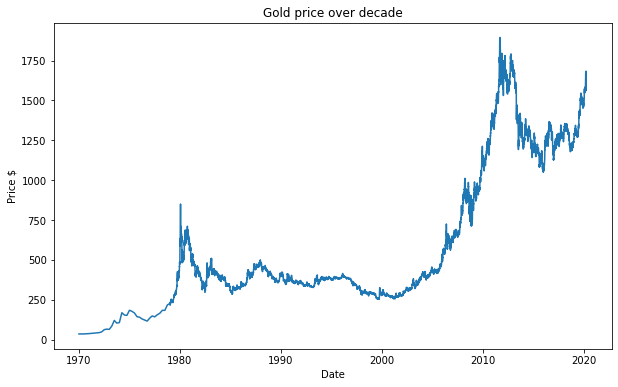

In [8]:
plt.xlabel('Date')
plt.ylabel('Price $')
plt.title('Gold price over decade')
plt.plot(indexedDataset)

In [9]:
rolmean = indexedDataset.rolling(window=500).mean()
rolstd = indexedDataset.rolling(window=500).std()
print(rolmean, rolstd)

                Value
Date                 
1970-01-01        NaN
1970-04-01        NaN
1970-07-01        NaN
1970-10-01        NaN
1971-01-01        NaN
...               ...
2020-03-09  1355.8198
2020-03-10  1356.4533
2020-03-11  1357.0593
2020-03-12  1357.5180
2020-03-13  1357.9562

[10787 rows x 1 columns]                  Value
Date                  
1970-01-01         NaN
1970-04-01         NaN
1970-07-01         NaN
1970-10-01         NaN
1971-01-01         NaN
...                ...
2020-03-09  125.633384
2020-03-10  126.344732
2020-03-11  127.042052
2020-03-12  127.398765
2020-03-13  127.727525

[10787 rows x 1 columns]


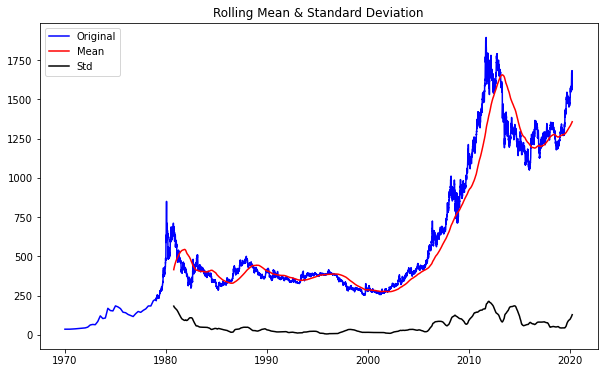

In [10]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Mean')
std = plt.plot(rolstd, color='black', label='Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [26]:
dates = indexedDataset.index.values
price = indexedDataset['Value']
data = pd.DataFrame(price)
dataset = data.values

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(dataset))

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dates, scaled_data, test_size=0.2, shuffle=False)
print(y_train)
print(y_train.shape)

[[5.37663315e-05]
 [0.00000000e+00]
 [1.61298995e-04]
 ...
 [9.20425829e-01]
 [9.18812839e-01]
 [8.99456960e-01]]
(8629, 1)


In [35]:
feature_train = []
label_train = []
time_steps = 500
n_cols = 1

for i in range(time_steps, len(y_train)):
    feature_train.append(y_train[i-time_steps:i, :n_cols])
    label_train.append(y_train[i, :n_cols])

In [37]:
x_train, Y_train = np.array(feature_train), np.array(label_train)

print(x_train.shape, Y_train.shape)

(8129, 500, 1) (8129, 1)


In [38]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [41]:
train_set = windowed_dataset(x_train, window_size=500, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(500, return_sequences=True),
    tf.keras.layers.LSTM(560),

    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),

    tf.keras.layers.Dense(1),
])

In [42]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=100)

Epoch 1/100


ValueError: ignored